## Package required

In [922]:
from warnings import filterwarnings

filterwarnings("ignore")

In [923]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import numpy as np



from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [924]:
X_train=pd.read_table("ada_train.data",delim_whitespace=True,header=None)
X_valid=pd.read_table("ada_valid.data",delim_whitespace=True,header=None)
X_test=pd.read_table("ada_test.data",delim_whitespace=True,header=None)


y_train=pd.read_table("ada_train.labels",delim_whitespace=True,header=None)
y_valid=pd.read_table("ada_valid.labels",delim_whitespace=True,header=None)


Column_train={"X"+str(i):X_train.iloc[:,i-1] for i in range(1,X_train.shape[1]+1)}
Column_valid={"X"+str(i):X_valid.iloc[:,i-1] for i in range(1,X_valid.shape[1]+1)}
Column_test={"X"+str(i):X_test.iloc[:,i-1] for i in range(1,X_test.shape[1]+1)}


In [925]:
ada_train_data=pd.DataFrame(Column_train)
ada_valid_data=pd.DataFrame(Column_valid)
ada_test_data=pd.DataFrame(Column_test)

ada_train_label=pd.DataFrame({"target":y_train.iloc[:,0]})
ada_valid_label=pd.DataFrame({"target":y_valid.iloc[:,0]})

In [926]:
ada_train_data.shape,ada_valid_data.shape,ada_test_data.shape

((4147, 48), (415, 48), (41471, 48))

In [927]:
ada_train_label.shape,ada_valid_label.shape

((4147, 1), (415, 1))

In [928]:
### Check for NaN

ada_train_data.isna().any().sum(),ada_valid_data.isna().any().sum(),ada_test_data.isna().any().sum()

(0, 0, 0)

There are no NaN values in our data

In [929]:
### Data types

numerical_cols=ada_train_data.columns[ada_train_data.nunique()>2]
categorical_cols=ada_train_data.columns[ada_train_data.nunique()<=2]

In [930]:
### Get descriptive statistics from numerical data

ada_train_data[numerical_cols].describe()

,X4,X10,X15,X25,X32,X40
count,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000
mean,126.408006,20.033036,631.886665,429.348686,10.964070,411.804196
std,69.754074,91.933304,161.410107,146.029831,76.318757,119.999993
min,13.000000,0.000000,62.000000,189.000000,0.000000,10.000000
25%,78.500000,0.000000,562.000000,311.000000,0.000000,404.000000
50%,119.000000,0.000000,624.000000,411.000000,0.000000,404.000000
75%,160.000000,0.000000,812.000000,522.000000,0.000000,454.000000
max,995.000000,648.000000,999.000000,999.000000,999.000000,999.000000


<AxesSubplot: >

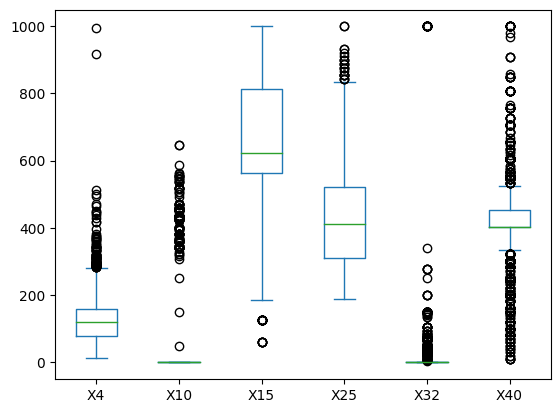

In [931]:
ada_train_data[numerical_cols].plot(kind="box")

Evidently we are facing 

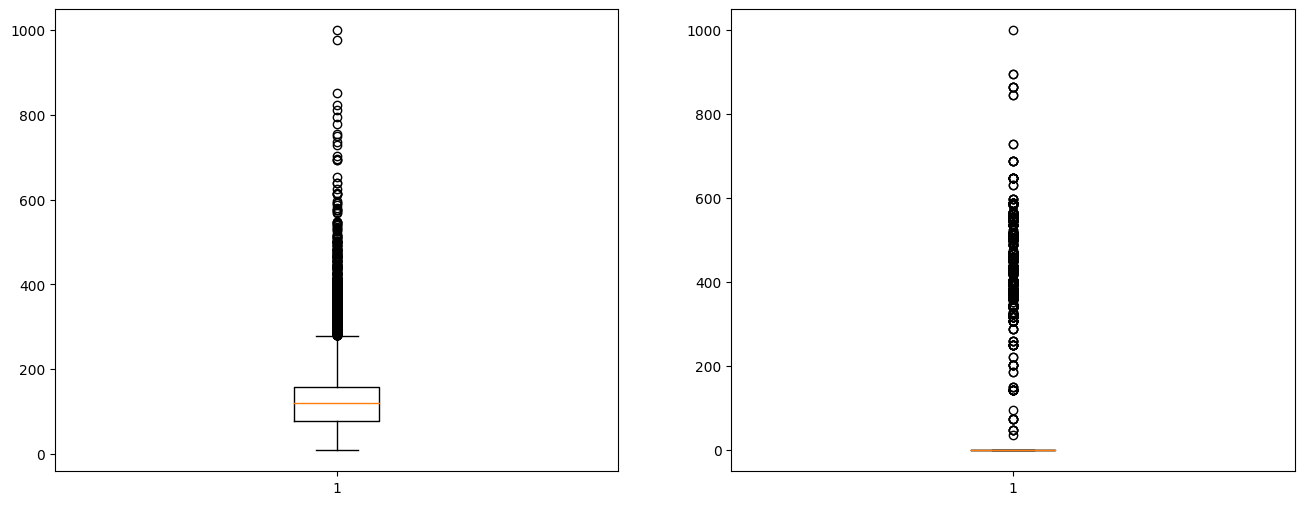

In [932]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[0]])
axs[1].boxplot(ada_test_data[numerical_cols[1]])
plt.show()

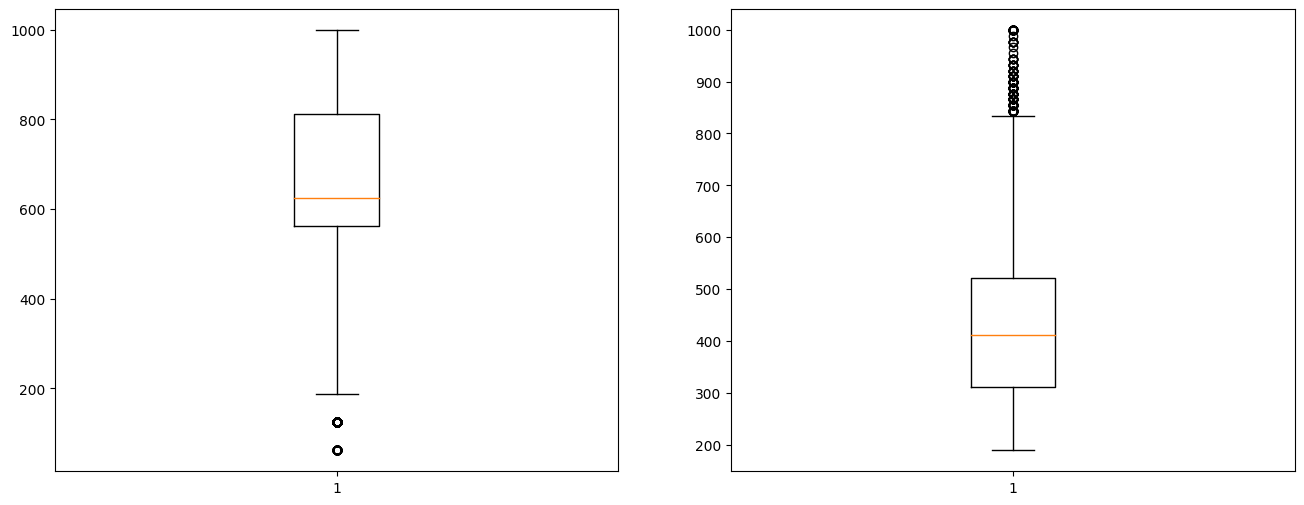

In [933]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[2]])
axs[1].boxplot(ada_test_data[numerical_cols[3]])
plt.show()

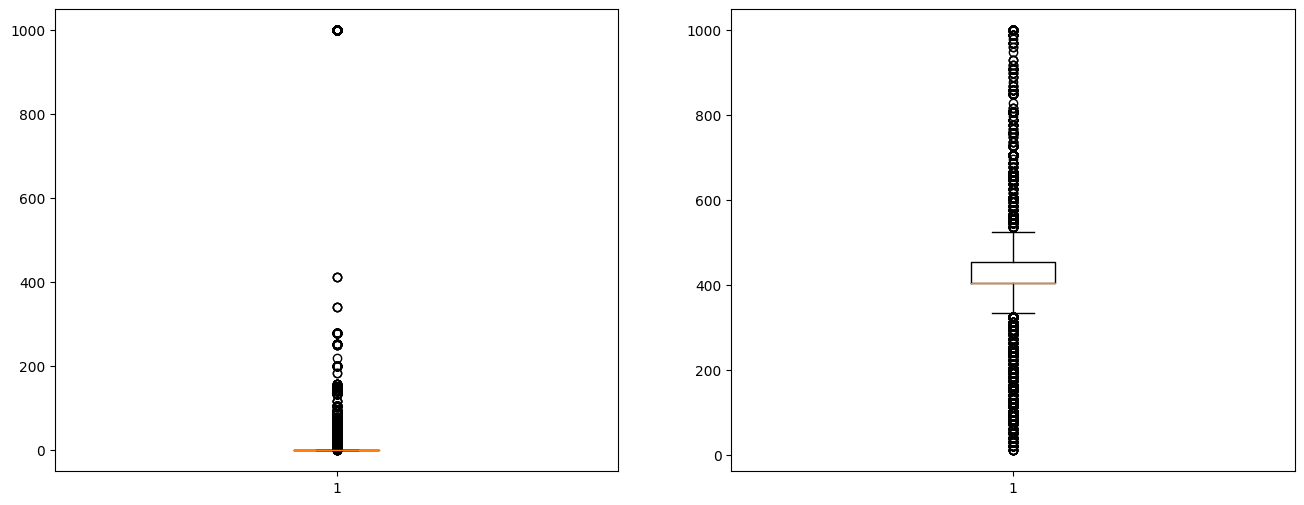

In [934]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[4]])
axs[1].boxplot(ada_test_data[numerical_cols[5]])
plt.show()

### Outlier handling

According to the expert of data, outliers is the bigest problem that can introduce biais in analysis and hide generally tendancy most of time especially when data size is small.

There many scenarios that can worthy and very bad but there not pre-defined strategies to get directly the best strategies to handle outliers. Even if, we have this problem; according to problematic some strategies will be more useful than others.

- Filtered test data set to avoid outliers
- 

In [935]:
ada_train_data.nunique().max(),ada_train_data.nunique().min()

(330, 1)

In [936]:
ada_train_data.X21.unique(),ada_valid_data.X21.unique(),ada_test_data.X21.unique()

(array([0]), array([0]), array([0]))

In [937]:
#The column contains just a unique value then it's not useful for discrimination

ada_train_data=ada_train_data.drop(columns=['X21'])
ada_valid_data=ada_valid_data.drop(columns=['X21'])
ada_test_data=ada_test_data.drop(columns=['X21'])

In [938]:
def get_percentage_of_outlier(df):

    numerical_cols=df.columns[df.nunique()>2]
    
    n=df.shape[0]

    outlier_size={}
 
    for col in numerical_cols:

        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        IQR=q3-q1

        outliers_shape=df[(df[col]<q1-1.5*IQR)].shape[0] + df[(df[col]>q3+1.5*IQR)].shape[0]

        outlier_size[col]=outliers_shape

    return outlier_size

In [939]:
get_percentage_of_outlier(ada_train_data)

{'X4': 98, 'X10': 193, 'X15': 25, 'X25': 24, 'X32': 336, 'X40': 1108}

### Modelisation

In [940]:
Classifiers=[KNeighborsClassifier,
             LogisticRegression,
             DecisionTreeClassifier,
             GaussianNB,
             LinearDiscriminantAnalysis]

In [941]:
ada_train_data.shape,ada_train_label.shape

((4147, 47), (4147, 1))

#### Before outlier handling

In [942]:
### Data Normalisation

def normalize_num_cols(df):

    df_standard=df.copy()

    standardizing=StandardScaler()
    
    numerical_cols=df.columns[df.nunique()>2]

    standar_col_num=standardizing.fit_transform(df[numerical_cols])

    df_standard[numerical_cols]=standar_col_num

    return df_standard

In [943]:
def get_accuray(train_set,train_label,valid_set,valid_label,cv=50):

    col=["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]
    df=pd.DataFrame(columns=col)
    for classifier in Classifiers:
        Name=classifier.__name__
        model=classifier().fit(train_set,train_label)
        y_pred=model.predict(valid_set)
        acc=np.mean(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER=np.mean(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC=np.mean(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))

        acc_std=np.std(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER_std=np.std(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC_std=np.std(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))
        #acc=metrics.accuracy_score(valid_label,y_pred)
        #BER=metrics.balanced_accuracy_score(valid_label,y_pred)
        #ROC=metrics.roc_auc_score(valid_label,y_pred)

        df1=pd.DataFrame([[Name,acc,BER,ROC,acc_std,BER_std,ROC_std]],columns=col)
        df=df.append(df1)

    return df

In [944]:
accuracy_df=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [945]:
### For normalized data

ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

#### After handling

In [946]:
from sklearn.impute import KNNImputer

def replace_outlier(x,min_whisker,max_whisker):

    if x<min_whisker or x>max_whisker:

        x=np.NaN
    
    return x


def fill_outlier(df_ada,method):

    numerical_cols=df_ada.columns[df_ada.nunique()>2]
 
    for col in numerical_cols:

        q1=df_ada[col].quantile(0.25)
        
        q3=df_ada[col].quantile(0.75)

        IQR=q3-q1

        min_whisker=q1-1.5*IQR
        max_whisker=q3+1.5*IQR

        df_ada[col]=df_ada[col].apply(lambda x: replace_outlier(x,min_whisker,max_whisker))

    if method=="mean":
            
        df_ada=df_ada.fillna(df_ada.mean())
        
    if method=="knn":
            
        imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

        df_ada[numerical_cols]=imputer.fit_transform(df_ada[numerical_cols])
    
    return df_ada

In [947]:
ada_train_data=fill_outlier(ada_train_data,method="knn")
ada_valid_data=fill_outlier(ada_valid_data,method="knn")

accuracy_df_outlier_trim=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [948]:
ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_outlier_trim_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

In [949]:
accuracy_df["data"]="raw"
accuracy_df_stand["data"]="raw_standard"
accuracy_df_outlier_trim["data"]="outlier_trimmed by mean"
accuracy_df_outlier_trim_stand["data"]="outlier_trimmed by mean and standard"

accuracies=[accuracy_df,accuracy_df_stand,accuracy_df_outlier_trim,accuracy_df_outlier_trim_stand]

accuracies_df=pd.concat(accuracies)

In [974]:
accuracies_df.sort_values(by="Accuracy_mean",ascending=False)

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std,data
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259,raw_standard
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw_standard
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802,raw_standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean and standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean
0,LogisticRegression,0.833864,0.746569,0.886386,0.038389,0.054891,0.039575,outlier_trimmed by mean and standard
0,LogisticRegression,0.831699,0.748389,0.882397,0.037602,0.056776,0.044011,raw
0,LogisticRegression,0.829518,0.740042,0.874568,0.034999,0.052856,0.042384,outlier_trimmed by mean
0,KNeighborsClassifier,0.815783,0.749339,0.843623,0.041793,0.052984,0.049040,outlier_trimmed by mean and standard


We find that the best model is build with standardized row data without outlier trimmed

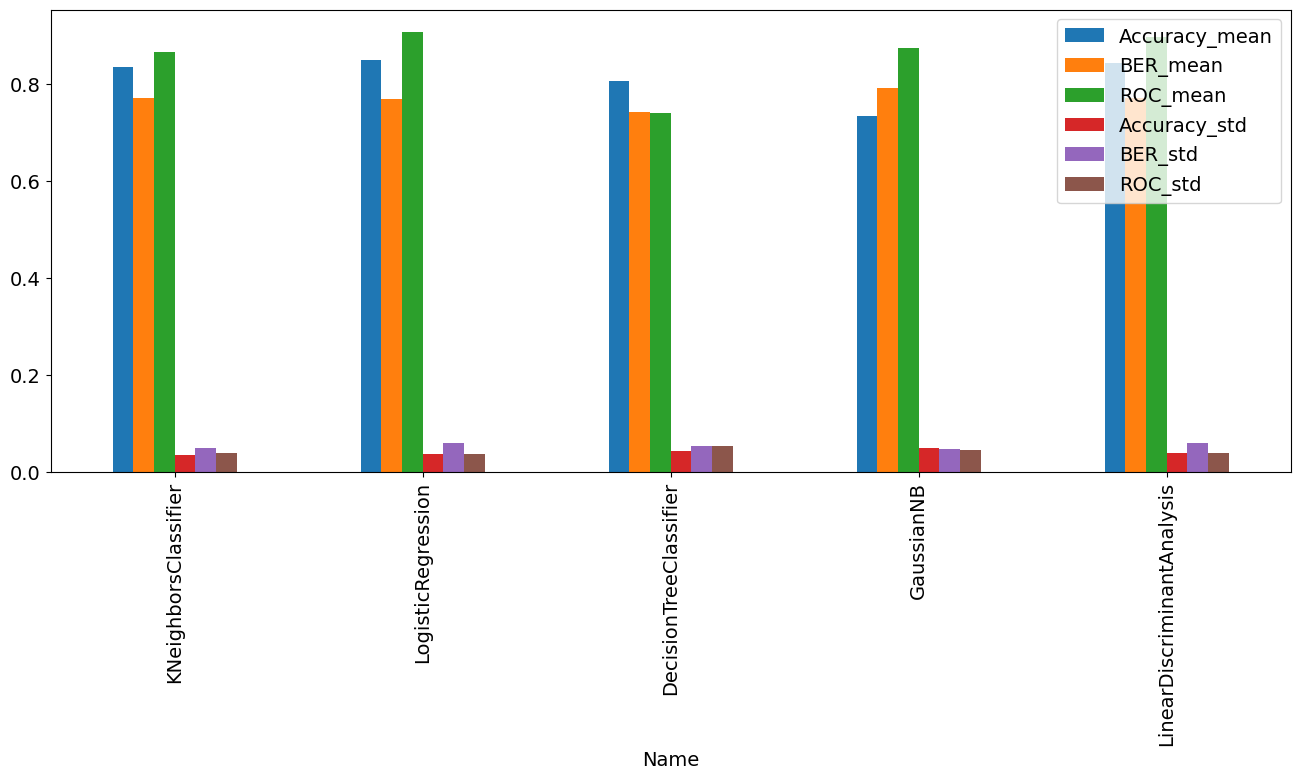

In [985]:
accuracies_df[accuracies_df["data"]=="raw_standard"][["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]].plot(kind="bar",x="Name",figsize=(16,6))

plt.show()